In [407]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  
pd.set_option("display.precision", 8)

In [408]:
#we assume risk free rate remains stable at 0.13
R_f = 0.13

In [409]:
#load data
industry_portfolio_df = pd.read_excel('Industry_Portfolios.xlsx')
industry_portfolio_df = industry_portfolio_df.drop(['Date'],axis =1)
market_portfolio_df = pd.read_excel('Market_Portfolio.xlsx')
market_portfolio_df = market_portfolio_df.drop(['Date'],axis =1)
concated_df = pd.concat([industry_portfolio_df,market_portfolio_df],axis=1)
concated_df_mean = concated_df.mean().to_numpy()
concated_excess_df = concated_df - R_f

c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\kilo\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [410]:
# regression for market model
market_model_result =[]
for n,portfolio in enumerate(concated_excess_df.columns):
    y = concated_excess_df[portfolio].to_numpy()
    x = concated_excess_df['Market'].to_numpy()
    market_model_result.append(np.polyfit(x,y,1)[::-1])

In [430]:
# regression result output
regression_result = np.column_stack((concated_excess_df.columns, market_model_result))
regression_result_df = pd.DataFrame(regression_result)\
    .rename(columns={0:'portfolio name',1:'y intercept',2:'slope'})
regression_result_df
print(regression_result_df.to_latex(index=False,
                  float_format="{:.5f}".format,
))

\begin{tabular}{lll}
\toprule
portfolio name & y intercept &   slope \\
\midrule
         NoDur &     0.36944 & 0.65265 \\
         Durbl &    -0.41560 & 1.64854 \\
         Manuf &     0.15977 & 1.16985 \\
         Enrgy &     0.50172 & 0.96985 \\
         HiTec &    -0.06402 & 1.13297 \\
         Telcm &     0.19469 & 0.90073 \\
         Shops &     0.27549 & 0.82649 \\
          Hlth &     0.23784 & 0.67304 \\
         Utils &     0.44458 & 0.53809 \\
         Other &    -0.38713 & 1.20731 \\
        Market &    -0.00000 & 1.00000 \\
\bottomrule
\end{tabular}



C:\Users\kilo\AppData\Local\Temp\ipykernel_12808\3501419658.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(regression_result_df.to_latex(index=False,


## SECURITY MARKET LINE ! ##

In [431]:
#prepare data for security market line
sml_data = np.column_stack((concated_excess_df.columns,\
                            regression_result_df['slope'].to_numpy(),\
                            concated_df.mean().to_numpy() ))
sml_data_df = pd.DataFrame(sml_data).rename(columns={0:'portfolio name',1:'estimated beta from regression',2:'portfolio mean'})
sml_data_df
print(sml_data_df.to_latex(index=False,
                  float_format="{:.5f}".format,
))

\begin{tabular}{lll}
\toprule
portfolio name & estimated beta from regression & portfolio mean \\
\midrule
         NoDur &                        0.65265 &        0.90283 \\
         Durbl &                        1.64854 &        0.73333 \\
         Manuf &                        1.16985 &        1.01283 \\
         Enrgy &                        0.96985 &        1.23117 \\
         HiTec &                        1.13297 &        0.76625 \\
         Telcm &                        0.90073 &        0.88142 \\
         Shops &                        0.82649 &        0.91633 \\
          Hlth &                        0.67304 &        0.78383 \\
         Utils &                        0.53809 &        0.90717 \\
         Other &                        1.20731 &        0.48908 \\
        Market &                        1.00000 &        0.74808 \\
\bottomrule
\end{tabular}



C:\Users\kilo\AppData\Local\Temp\ipykernel_12808\4151561814.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sml_data_df.to_latex(index=False,


In [440]:
# regression for SML
sml_x = list(sml_data_df['estimated beta from regression'].to_numpy())
sml_y = list(sml_data_df['portfolio mean'].to_numpy())
sml_result = np.polyfit(sml_x,sml_y,1)
sml_slope = sml_result[0]
sml_intercept = sml_result[1]
print(sml_x)
print(sml_x[0:-1])

[0.652647355963541, 1.648535649966647, 1.1698462964148781, 0.9698499564640055, 1.1329694391423129, 0.9007292509476117, 0.8264924015201599, 0.6730356956329144, 0.5380861001316399, 1.2073094586151105, 1.0000000000000002]
[0.652647355963541, 1.648535649966647, 1.1698462964148781, 0.9698499564640055, 1.1329694391423129, 0.9007292509476117, 0.8264924015201599, 0.6730356956329144, 0.5380861001316399, 1.2073094586151105]


In [459]:
print(f'sml intercept = {sml_intercept}')
print(f'sml slope = {sml_slope}')

sml intercept = 1.0327683682657058
sml slope = -0.18546745836573278


In [414]:
#create y points for SML graph plotting
possible_beta  = np.arange(0,2.01,0.01)
sml_return = []
for x in possible_beta:
    y = sml_intercept + sml_slope * x
    sml_return.append(y)

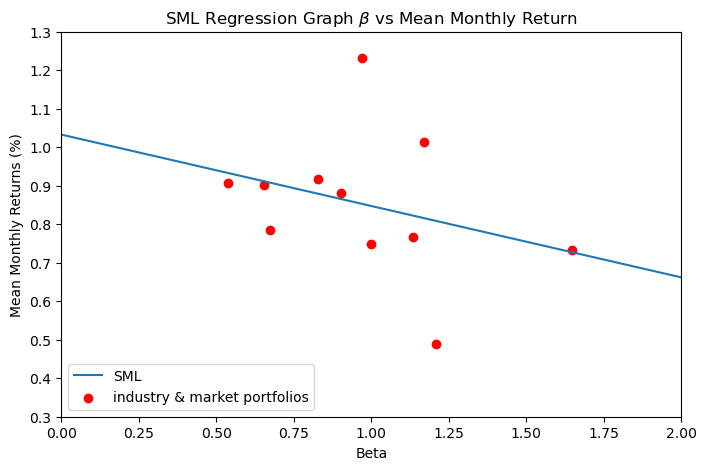

In [462]:
f1,ax1 = plt.subplots(1,figsize=(8, 5))
#ax1.set(xlim=(0,2), ylim=(0,1.5), aspect='equal')
ax1.plot(possible_beta,sml_return,label='SML')
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.10))
ax1.set(xlim=(0,2),ylim=(0.3,1.3))
ax1.set_xlabel('Beta')
ax1.set_ylabel('Mean Monthly Returns (%)')
ax1.set_title(r'SML Regression Graph ${\beta}$ vs Mean Monthly Return')
#for port_x,port_y,label in list(zip(,,sml_label)) :
ax1.scatter(sml_x, sml_y,label='industry & market portfolios',color='red')
ax1.legend(loc='lower left')

plt.show(f1)
f1.savefig('sml.jpg')

In [ ]:
#fun experiment, lets do multiple subplots !
plt.figure(figsize=(30, 20))
for n,portfolio in enumerate(concated_excess_df.columns):
    #add new subplots
    ax = plt.subplot(4,3,n+1)
    ax.scatter(concated_excess_df[portfolio],concated_excess_df['Market'])
    # chart formatting
    ax.set_title(portfolio.upper())
    ax.set_xlabel("")
    #ax.set_xlim(xmin=0)
    #ax.set_ylim(ymin=0)
    ax.set(xlim=(-15,15), ylim=(-15,15), aspect='equal')

    # Set bottom and left spines as x and y axes of coordinate system
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)